# Gruppenprojekt Algorithmik & Statistik 2
Authors: Andreas Bleyel, Birgit Breitenlechner, Thomas Honeder, Cosmin Iacob

# Ames House Prices  - Advanced Regression Techniques


![HousesImage](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

# Introduction

## Der Datensatz
Bei dem gewählten Datensatz handelt es sich um den Ames Housing Datensatz. Dieser Datensatz wurde von Dean De Cock als eine aktuelle Alternative zum veralteten Boston Housing Dataset erstellt. Die Daten enthalten alle Immobilientransaktionen aus Ames, Iowa, zwischen 2006 und 2010. Im Vergleich dazu, sind die Daten des Boston Housing Datensatz aus dem Jahr 1970 und die Preise nicht länger realistisch (“The original data set is from the 70’s and the housing prices have become unrealistic for today’s market.”)

Der Datensatz enthält 2919 Daten verteilt in 1460 Training- und 1459 Testdaten. Jede Immobilie ist mit Hilfe von 80 Variablen beschrieben. Es gibt 43 Factors mit 2 bis 25 Levels. Außer den Factors sind 37 Integer Variablen vorhanden. Die Zielvariable ist SalePrice. Zu den wichtigsten Prädiktoren gehören unserer Meinung nach YearBuilt, YrSold, LotArea (Integer), LotConfig, Neighborhood und HouseStyle. Für Erstellung des Modells könnte man die Integer Prädiktoren in Factor umwandeln z.B.: BsmtFullBath, GarageCars oder einen neuen Prädiktor erstellen z.B.: IstHausRemodeliert.

## Warum wurde dieser Datensatz gewählt
Den Datensatz haben wir gewählt, da es privat für uns Studierende durchaus nützlich zu wissen sein kann, welche Faktoren sich auf den Preis von Immobilien auswirken. Außerdem eignen wir uns in diesem Bereich ein Basisdomänenwissen an, das in Kombination mit Data Science zu interessanten und vielversprechenden Karrierechancen führen kann. Immer mehr Unternehmen, die im Immobiliengeschäft tätig sind, setzen auf automatisierte und informationsunterstützte Analyseverfahren, da sie sich so von ihren Konkurrenten abheben können.

Ein weiterer Grund war, dass der Datensatz viele Variablen enthält, was uns dementsprechend auch viele Möglichkeiten bietet Features zu analysieren und daraus Erkenntnisse über die Daten zu gewinnen.

# Methods

## Ein blauäugiger Start
Eine statistische Analyse startet normalerweise mit einer explorativen Auseinandersetzung mit den Daten. Erst nach Untersuchung der verschiedenen Verteilungen, Kontrolle und Bearbeitung von fehlenden Werten, Auswahl relevanter Features und Skalierungsmaßnahmen widmet man sich der Erstellung der Modelle. Das werden wir an dieser Stelle nicht tun. Wir starten  sofort mit einem Random Forest Model, das alle Features berücksichtigt. Naiv werden alle fehlende kategoriale Werte als "missing" gekennzeichnet, fehlende numerische Daten werden mit dem entsprechenden Median aufgefüllt. Die Wahl auf den Random Forest fiel ohne genauere Vorüberlegungen, folglich werden keine individuellen Parameter verwendet, sondern auf die Standardwerte von sklearn zurückgegriffen. Uns interessiert an dieser Stelle, welche Test-RMSE wir generieren können, ohne genaueres über unsere Daten zu wissen. Im Anschluss werden wir zum empfohlenen Weg zurückkehren und unsere Daten explorativ untersuchen, Feature Engineering betreiben und verschiedene Modelle durchtesten, um hoffentlich die Test RMSE unseres 'Erst-Modells' unterbieten zu können.

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import eli5

from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler
from matplotlib import pyplot as plt
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, median_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from eli5.sklearn import PermutationImportance
from helper_functions import *
from pprint import pprint

#hide python & javascript warnings
import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

#### Laden der Daten
Die Daten aus der csv Datei werden mit der pandas Methode 'read_csv' in die Variable 'data' übergeben.

In [2]:
data = pd.read_csv("train.csv")

#### Median Imputation
Als Imputation bezeichnet man das Auffüllen von fehlenden Beobachtungen. Dafür gibt es eine Vielzahl verschiedener Methoden. Für numerische Werte eignet sich bspw. die Median Imputation. Wie der Name schon verrät werden dabei fehlende Werte mit dem Median den vorhandenen Beobachtungen der Variable aufgefüllt. An dieser Stelle wird der Median Imputer des Pakets sklearn.SimpleImputer verwendet. 

In [3]:
simple_imputer = SimpleImputer(strategy='median')

data['LotFrontage'] = simple_imputer.fit_transform(data[['LotFrontage']])
data['MasVnrArea'] = simple_imputer.fit_transform(data[['MasVnrArea']])
data['GarageYrBlt'] = simple_imputer.fit_transform(data[['GarageYrBlt']])

#### Konstante Imputation
Kategoriale Daten weisen keine natürliche Reihenfolge auf. Dadurch kann auch kein Median ermittelt und folglich auch keine Median Imputation durchgeführt werden. Dennoch lässt sich bei Daten, die keine natürliche Ordnung aufweisen, ein weiterer Lageparameter ermitteln. Der sogenannte Modus gibt an, welche Ausprägung der Variable am häufigsten vorkommt. Auch so kann eine Imputation durchgeführt werden.
Eines darf bei der Diskussion um fehlende Daten jedoch nicht außer Acht gelassen werden. In den meisten Fällen gibt es einen Grund für das Fehlen der Ausprägung. Auch im vorliegenden Fall gibt es einen einfachen Grund für die fehlenden Werte im Datensatz. Die NaN Werte bedeuten schlichtweg, dass die Ausprägung nicht existiert. So bedeutet NaN beim feature 'GarageType' bspw., dass keine Garage vorhanden ist. Deshalb werden für eine Reihe von features die fehlenden Werte mit dem Begriff 'missing' aufgefüllt. So kann im weiteren Verlauf Dummy-Encoding weiterhin eingesetzt werden, was mit NaN als Ausprägung nicht möglich ist.

In [4]:
simple_imputer = SimpleImputer(strategy='constant', fill_value = 'missing')

data['Alley'] = simple_imputer.fit_transform(data[['Alley']])
data['MasVnrType'] = simple_imputer.fit_transform(data[['MasVnrType']])
data['BsmtQual'] = simple_imputer.fit_transform(data[['BsmtQual']])
data['BsmtCond'] = simple_imputer.fit_transform(data[['BsmtCond']])
data['BsmtExposure'] = simple_imputer.fit_transform(data[['BsmtExposure']])
data['BsmtFinType1'] = simple_imputer.fit_transform(data[['BsmtFinType1']])
data['BsmtFinType2'] = simple_imputer.fit_transform(data[['BsmtFinType2']])
data['Electrical'] = simple_imputer.fit_transform(data[['Electrical']])
data['FireplaceQu'] = simple_imputer.fit_transform(data[['FireplaceQu']])
data['GarageType'] = simple_imputer.fit_transform(data[['GarageType']])
data['GarageFinish'] = simple_imputer.fit_transform(data[['GarageFinish']])
data['GarageQual'] = simple_imputer.fit_transform(data[['GarageQual']])
data['GarageCond'] = simple_imputer.fit_transform(data[['GarageCond']])
data['PoolQC'] = simple_imputer.fit_transform(data[['PoolQC']])
data['Fence'] = simple_imputer.fit_transform(data[['Fence']])
data['MiscFeature'] = simple_imputer.fit_transform(data[['MiscFeature']])

#### Fehlende Daten
Nach der Imputation sind keine fehlenden Daten mehr vorhanden.

In [5]:
data.isna().sum().sum()

0

#### Dummy Encoding
Um die Maschinenlesbarkeit unserer Daten zu verbessern, wird an dieser Stelle für die kategorialen features ein Dummy Encoding durchgeführt. Dummy Encoding bedeutet, dass die Beobachtungen zukünftig binär erklärt werden. Ein kurzes Beispiel: Für ein feature das die Werte 'rot', 'grün' und 'blau' enthält, werden drei neue Spalten generiert. Hatte die ursprüngliche Spalte die Ausprägung 'rot' weißt die neue generierte erste Spalte den Wert 1 auf, die zweite und dritte Spalte hingegen werden mit 0 aufgefüllt.

In [6]:
data = pd.get_dummies(data)

#### Train Test Split
In folgenden 'chunk' werden die Daten als erstes in input- und outputfeatures aufgeteilt und dann zufällig in ein Trainings- und Testset aufgeteilt. Eine Aufteilung der Daten ist deshalb wichtig, da beim Training auf den kompletten Daten ein overfitting wahrscheinlich wäre. Ein Split von 20% bedeutet, dass unser Modell mit 80% der Daten trainiert und mit den verbleibenden 20% validiert wird. In welcher Höhe der Split durchgeführt wird, hängt auch mit Größe des Datensatzes zusammen. Allgemein lässt sich jedoch festhalten, dass bei weniger Trainingsdaten die Modellparameter eine höhere Varianz aufweisen und umgekehrt, bei zu wenig Testdaten, die Varianz der Modellperformanz steigen kann. Auch im Zusammenhang mit dem Pareto Prinzip ist der 80/20 Split in der Statistik weit verbreitet.

In [7]:
input_features = data.columns
input_features = input_features.drop("SalePrice")

output_features = ['SalePrice']

train_X, test_X, train_y, test_y = train_test_split(
    data[input_features], 
    data[output_features],
    random_state=123,
    test_size=0.20
)

#### shape
Mit der 'shape' Methode wird überprüft, ob die Dimensionen der Trainings- und Testdaten übereinstimmen.

In [8]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((1168, 305), (292, 305), (1168, 1), (292, 1))

#### Random Forest
Die Wahl des Random Forest an dieser Stelle erfolgte, wie bereits erwähnt, außer guten Erfahrungen bei vergangenen Problemstellungen keiner genaueren Vorüberlegung. 
Random Forests zählen zu den Ensemble Methoden. Sie bestehen aus vielen einzelnen Decision Trees. Für die einzelnen Bäume  werden jedoch nicht alle Prädiktoren verwendet, sondern eine zufällige Teilmenge davon. Am Ende werden die einzelnen Decision Trees zu einem großen Modell kombiniert. Die Ergebnisse der Bäume werden anhand eines Maturity Votings berechnet. Random Forests liefern robuste und zuverlässige Outcomes und sind nicht zuletzt wegen ihrer Skalierbarkeit sehr etabliert.

Wie weiter oben bereits angeführt wird die Anzahl der Einzelbäume auf der Standardeinstellung von sklearn belassen. Der random-state dient der Reproduzierbarkeit.

In [9]:
rfg = RandomForestRegressor(random_state=123)

rfg = rfg.fit(train_X, train_y)
rfg_pred = rfg.predict(test_X)

#### Prädiktion und Validierung
Unser Random Forest erreicht eine Test RMSE von ca. 29,000. Ob das gut ist oder nicht, kann an dieser Stelle nicht gesagt werden. Jedoch setzten wir uns diesen Wert als Benchmark und sind gespannt, ob wir ihn durch die folgenden explorativen Analysen, Feature Engineering und den Einsatz verschiedener Modelle verbessern können.

In [10]:
rmse_intro = np.sqrt(mean_squared_error(rfg_pred, test_y))
r2_intro = rfg.score(test_X, test_y)

print("RMSE: " + str(rmse_intro))

RMSE: 29183.49132524501


#### Model Importance
Anhand Model Importance lässt sich gut erkennen, dass die Variable 'OverallQal' einen enormen Einfluss auf die Responsevariable 'SalePrice' nimmt. Nach einem starken Ellbogen sieht man, dass auch die Wohnfläche einen wesentlichen Einfluss auf die Zielvariable nimmt.

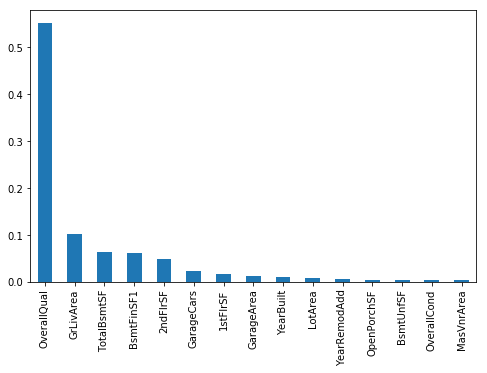

In [11]:
feat_imp = pd.Series(rfg.feature_importances_, index=input_features)
plt.figure(figsize=(8,5))
feat_imp.nlargest(15).plot(kind='bar')

# Inspektion des Datensets
Nachdem wir ohne genauere Betrachtung der Daten "blind" ein Random Forest Modell erstellt haben, wenden wir uns jetzt einer tieferen Analyse der Daten zu. Das Ziel wäre es, durch durchdachtes Feature-Engineering ein besseres Modell zu erstellen.

Zuerst wollen wir uns ansehen mit welchen Daten wir es hier überhaupt zu tun haben und welche Variablen zur Verfügung stehen.

In [12]:
train = pd.read_csv("train.csv")

In [13]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [14]:
train.shape

(1460, 81)

Unser Datensatz umfasst 81 Spalten sprich 80 potentielle Features und eine Ziel-Variable. Nachfolgend der Auszug aus der originalen Beschreibung des Datensatzes und der einzelnen Spalten:

- SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
- MSSubClass: The building class
- MSZoning: The general zoning classification
- LotFrontage: Linear feet of street connected to property
- LotArea: Lot size in square feet
- Street: Type of road access
- Alley: Type of alley access
- LotShape: General shape of property
- LandContour: Flatness of the property
- Utilities: Type of utilities available
- LotConfig: Lot configuration
- LandSlope: Slope of property
- Neighborhood: Physical locations within Ames city limits
- Condition1: Proximity to main road or railroad
- Condition2: Proximity to main road or railroad (if a second is present)
- BldgType: Type of dwelling
- HouseStyle: Style of dwelling
- OverallQual: Overall material and finish quality
- OverallCond: Overall condition rating
- YearBuilt: Original construction date
- YearRemodAdd: Remodel date
- RoofStyle: Type of roof
- RoofMatl: Roof material
- Exterior1st: Exterior covering on house
- Exterior2nd: Exterior covering on house (if more than one material)
- MasVnrType: Masonry veneer type
- MasVnrArea: Masonry veneer area in square feet
- ExterQual: Exterior material quality
- ExterCond: Present condition of the material on the exterior
- Foundation: Type of foundation
- BsmtQual: Height of the basement
- BsmtCond: General condition of the basement
- BsmtExposure: Walkout or garden level basement walls
- BsmtFinType1: Quality of basement finished area
- BsmtFinSF1: Type 1 finished square feet
- BsmtFinType2: Quality of second finished area (if present)
- BsmtFinSF2: Type 2 finished square feet
- BsmtUnfSF: Unfinished square feet of basement area
- TotalBsmtSF: Total square feet of basement area
- Heating: Type of heating
- HeatingQC: Heating quality and condition
- CentralAir: Central air conditioning
- Electrical: Electrical system
- 1stFlrSF: First Floor square feet
- 2ndFlrSF: Second floor square feet
- LowQualFinSF: Low quality finished square feet (all floors)
- GrLivArea: Above grade (ground) living area square feet
- BsmtFullBath: Basement full bathrooms
- BsmtHalfBath: Basement half bathrooms
- FullBath: Full bathrooms above grade
- HalfBath: Half baths above grade
- Bedroom: Number of bedrooms above basement level
- Kitchen: Number of kitchens
- KitchenQual: Kitchen quality
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- Functional: Home functionality rating
- Fireplaces: Number of fireplaces
- FireplaceQu: Fireplace quality
- GarageType: Garage location
- GarageYrBlt: Year garage was built
- GarageFinish: Interior finish of the garage
- GarageCars: Size of garage in car capacity
- GarageArea: Size of garage in square feet
- GarageQual: Garage quality
- GarageCond: Garage condition
- PavedDrive: Paved driveway
- WoodDeckSF: Wood deck area in square feet
- OpenPorchSF: Open porch area in square feet
- EnclosedPorch: Enclosed porch area in square feet
- 3SsnPorch: Three season porch area in square feet
- ScreenPorch: Screen porch area in square feet
- PoolArea: Pool area in square feet
- PoolQC: Pool quality
- Fence: Fence quality
- MiscFeature: Miscellaneous feature not covered in other categories
- MiscVal: $-Value of miscellaneous feature
- MoSold: Month Sold
- YrSold: Year Sold
- SaleType: Type of sale
- SaleCondition: Condition of sale

Neben numerischen Features gibt es auch eine ganze Reihe von kategorialen Variablen. Um sie für unsere Modelle verwenden zu können, werden wir sie später in ein numerisches Format konvertieren.

In [15]:
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


## Ziel-Variable SalesPrice
Die Erwartung ist, dass es sich um einen numerischen Wert handelt welcher angibt, um welchen USD Betrag die Immobilie verkauft wurde. Da es sich um einen Verkaufspreis handelt, nehmen wir im Vorfeld an, dass es sich um keine Normalverteilung handeln wird und wir eine log-Transformierung vornehmen werden müssen. Negative Werte werden ebenfalls nicht erwartet. Lassen wir die Zahlen sprechen.

No NAs
No negative values
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
Head
0    208500
1    181500
2    223500
Name: SalePrice, dtype: int64


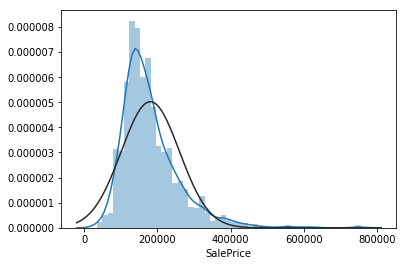

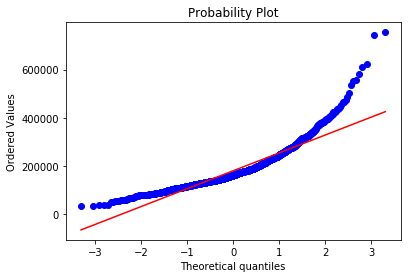

In [16]:
checkFeature('SalePrice', train, False)

Wie erwartet bestätigen sich die beiden Annahmen, dass es sich um keine Normalverteilung handelt und keine negativen Werte vorhanden sind. Die log-Transformation wird erst durchgeführt, nachdem wir die einzelnen wichtigen Features gefunden haben.

## Feature Selection
Zu Beginn ist gleich einmal zu sehen, dass wir es mit sehr vielen Feature-Variablen zu tun haben.
Eine Konzentration auf solche welche einen signifikanten Einfluss auf die Vorhersage der Ziel-Variable "Sales Price" haben, hat die höchste Priorität und wird zuerst behandelt. Ziel ist es, ein Modell nur mit den notwendigsten bzw. most-significant Features zu erstellen. Features ohne Signifikanz verursachen einerseits unnötigen Rechenaufwand und verringern die Qualität unseres Modells. Den Beginn macht die Ziel-Variable SalesPrice.

### Numerische Features

Für numerische Features bietet sich an, sich erstmal die Korrelationen anzusehen.

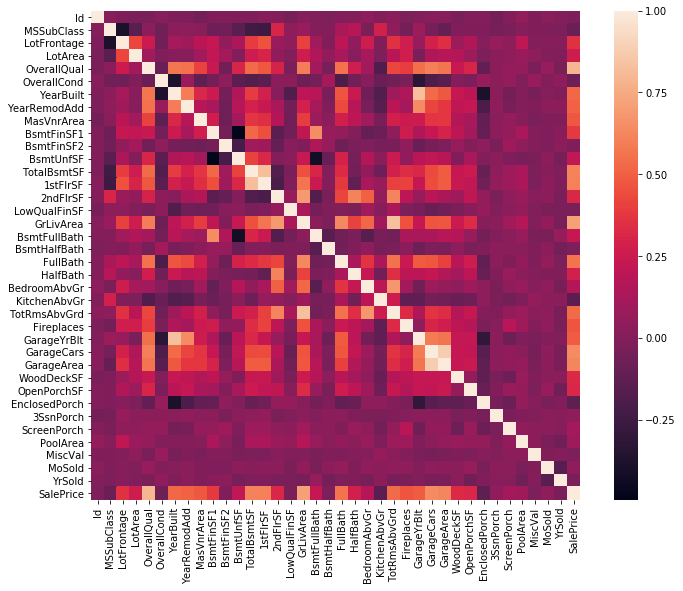

In [17]:
corr = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, square=True);

TotalBsmtSF mit 1FlrSF sowie GarageCars und GarageArea scheine eine hohe Korrelation zu haben. Dies macht auch Sinn da 1stFlrSF und TotalBsmtSF insofern korrelieren, da die Gesamtanzahl der m² und die des ersten Stockes meist sehr ähnlich wenn nicht sogar gleich sind. Genauso ist es nur logisch und leicht erklärbar, dass umso mehr Platz für Autos in einer Garage sind, auch die Fläche der Garage steigt. Zu hinterfragen wäre lediglich, ob eine Multikolinearität vorliegt und es nicht besser wäre, eine der beiden Variablen zu entfernen. Dazu dann später mehr wenn fehlende Werte untersucht werden und sich vielleicht ohnehin eine Variable dadurch von selbst anbietet.

Weitere Pärchen welche korrelieren:

* OverallQual scheint auch mit vielen anderen Variablen zu korrelieren. Auch das erscheint plausibel da schon die Bezeichnung "Overall" auf eine Bewertung von mehreren Attributen hindeutet. Vor allem mit SalePrice scheint (wenig überraschend) eine hohe Korrelation vorzuliegen.
* YearBuilt gemeinsam mit GaragyYrBlt ist auch rational erklärbar.
* GrLivArea und TotRmsAbvGrd.

Variablen welche mit SalesPrice in deutlichem Zusammenhang stehen und einer nähere Betrachtung Wert sind:

* OverallQual
* GarageArea / Cars
* GrLiveArea
* TotalBsmtSF

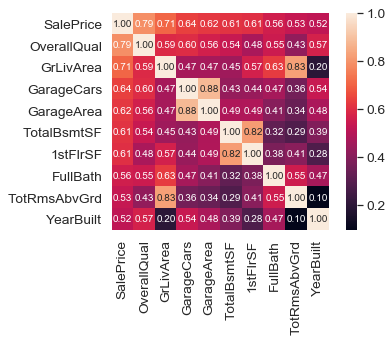

In [18]:
k = 10
cols = np.abs(corr).nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Aus diesen beiden Heatmaps lassen sich schon gute Kandidaten für eine nähere Betrachtung filtern. Diese werden in späterer Folge wohl eine wichtige Rolle spielen, daher nachfolgend nochmal eine Auflistung mit kurzer Beschreibung:

* YearBuilt - wann das Objekt erbaut wurde
* GarageAreas - Platz der Garage in square feet
* GrLivingArea - Wohnbereich über dem Grund in square fett
* FullBath - Volle Badzimmer über dem Grund. Interessat wäre noch zu wissen, was mit "Voll" gemeint ist.
* TotalBsmtSF - Summe der square feet des Untergeschosses
* OverallQual - Gesamtzustand des Objekts

#### Verfeinerung GarageArea / GarageCars
Der nächste Schritt ist es zu prüfen, welche Variable des Pärchens GarageArea/GarageCars für unser Modell genommen wird. GarageArea gibt vor, wieviele Cars Platz finden und bietet sich somit für eine Beibehaltung an. Trotzdem noch ein paar Checks um sicher zu gehen.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


No NAs
No negative values
count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64
Head
0    548
1    460
2    608
Name: GarageArea, dtype: int64


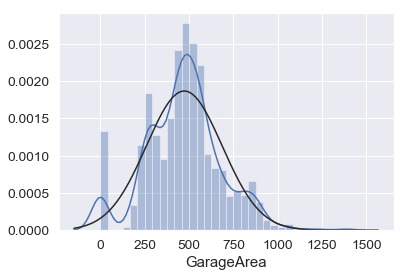

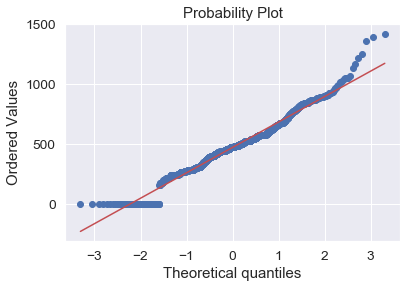

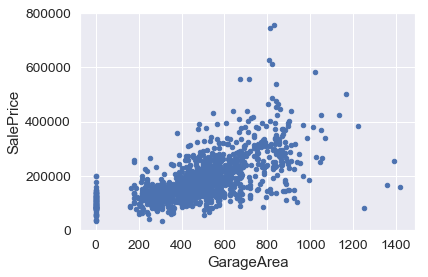

In [19]:
checkFeature('GarageArea', train, False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


No NAs
No negative values
count    1460.000000
mean        1.767123
std         0.747315
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: GarageCars, dtype: float64
Head
0    2
1    2
2    2
Name: GarageCars, dtype: int64


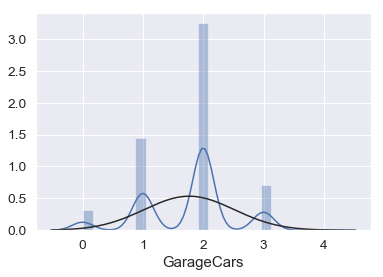

<Figure size 432x288 with 0 Axes>

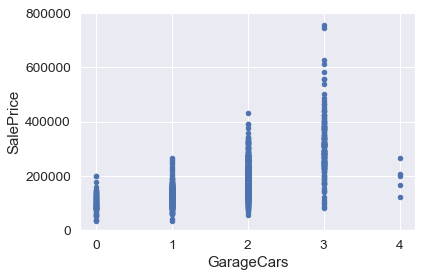

In [20]:
checkFeature('GarageCars', train, True)

Soweit keine fehlenden Werte aber natürlich Datensätze welche den Wert 0 in beiden Spalten enthalten vorhanden. Dies sind Anwesen ohne Garage was soweit Sinn ergibt. Auch die Anzahl ist ident. Daher belassen wir es vorerst bei GarageArea für die weitere Bearbeitung.

### Analyse der Feature-Variablen mit dem größten Einfluss
Wir werden nun die als wichtig identifizierten Feature Variablen in den nächsten Schritten einzeln unter die Lupe nehmen und gegebenfalls Anpassungen vornehmen.

#### Overall Quality

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


No NAs
No negative values
count    1460.000000
mean        6.099315
std         1.382997
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64
Head
0    7
1    6
2    7
Name: OverallQual, dtype: int64


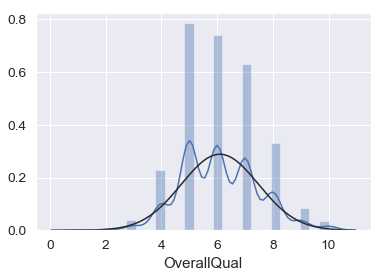

<Figure size 432x288 with 0 Axes>

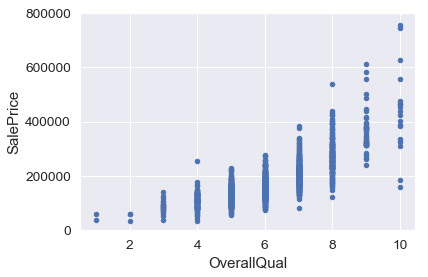

In [21]:
checkFeature('OverallQual', train, True)

OverallQual ist eine Aufteilung in 10 Wertungs-Kategorien. Beginnend bei 1 als schlechteste Kategorie, bishin zu 10 als beste. Dabei handelt es sich um int64 Ganzzahlen welche eventuell als kategoriale Variable dargestellt werden könnten. Da jedoch eine schöne Korrelation der OverallQual mit dem SalePrice vorhanden ist, behalten wir den numerischen Typ bei.

Wir sehen uns jetzt noch an, welche Featurs mit OverallQual korrelieren und damit vielleicht schon direkt davon abhängig sind.

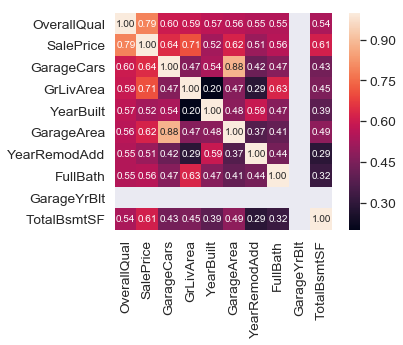

In [22]:
k = 10 
cols = np.abs(corr).nlargest(k, 'OverallQual')['OverallQual'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Wenig überraschend, steht OverallQual mit ähnlichen Variablen wie auch SalesPrice in Verbindung. Bei der Erstellung der Modelle, werden wir ein Modell welches SalePrice nur mit der OverallQual vorhersagt erstellen und prüfen, ob dies möglichweise schon ausreichend ist.

#### YearBuilt
Wann das Objekt erbaut wurde. Erwartet werden Ganzzahlen im üblichen Jahresformat, keine negativen und keine fehlenden Werte.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


No NAs
No negative values
count    1460.000000
mean     1971.267808
std        30.202904
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64
Head
0    2003
1    1976
2    2001
Name: YearBuilt, dtype: int64


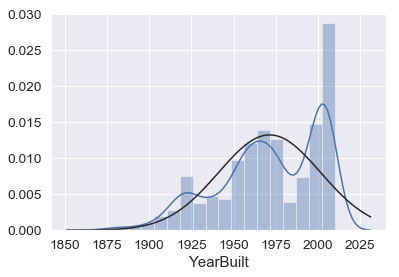

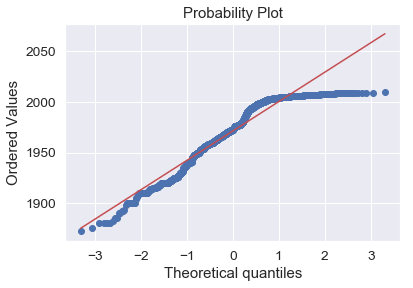

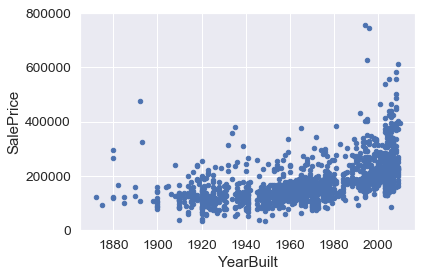

In [23]:
checkFeature('YearBuilt', train, False)

Es war zu erwarten, dass wir hier keine Normalverteilung vorfinden werden. Derzeit ist die Variable noch als numersicher Wert im Datenset. Eine Umwandlung durch OneHotEnconding ist je nach eingesetztem Algorithmus abzuwägen. Auch eine Einteilung in Kategorien wie zB "vor 1900", "1900-1930", "vor 1.WK" etc. könnte eine nähere Untersuchung wert sein. Vorerst ist wichtig, dass wir keine negativen oder fehlenden Werte haben. 

In Verbindung mit SalePrice ist eine schwache logarithmische Kurve (Anstieg) zu erkennen. Interessant wäre zu wissen, ob die Verkaufspreise der Vergangenheit Inflationsbereinigt wurden.

#### GarageArea
Platz der Garage in square feet. Erwartet werden float64 Werte, keine negativen und keine fehlenden Werte.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


No NAs
No negative values
count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64
Head
0    548
1    460
2    608
Name: GarageArea, dtype: int64


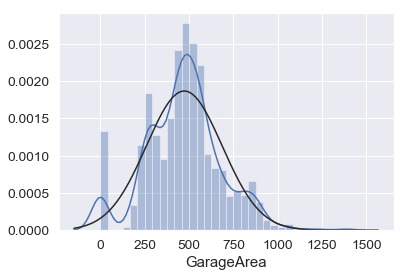

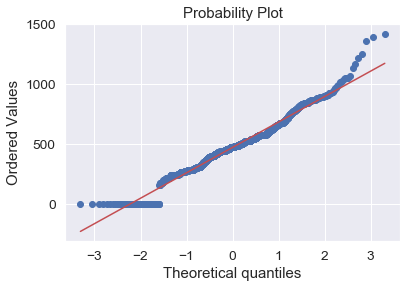

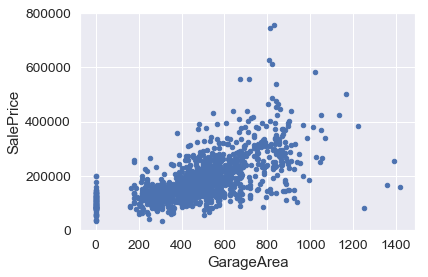

In [24]:
checkFeature('GarageArea', train, False)

In [25]:
printSkewKurt('GarageArea', train)

Skewness: 0.179981
Kurtosis: 0.917067


Die Verteilung geht schon in Richtung Normalverteilung könnte aber vielleicht durch eine log-Transformierung verbessert werden. Dies prüfen wir im nächsten Schritt. Natürlich gibt es die "Ausreißer" mit Wert 0, von Objekten welche keine Garage besitzen. Um diese müssen wir uns zuvor kümmer da wir 0 Werte nicht log-Transformieren können. 

Auffallend die die 4 Ausreißer rechts unten welche auf sehr große Garagen aber trotzdem einen niedrigen Verkaufspreis darstellen. Werfen wir einen genaueren Blick auf diese 4 Objekte.

In [26]:
train.nlargest(4, columns=['GarageArea'])

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
581,582,20,RL,98.0,12704,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2008,2009,Hip,CompShg,VinylSd,VinylSd,BrkFace,306.0,Ex,TA,PConc,Ex,TA,No,Unf,0,Unf,0,2042,2042,GasA,Ex,Y,SBrkr,2042,0,0,2042,0,0,2,1,3,1,Ex,8,Typ,1,Gd,Attchd,2009.0,RFn,3,1390,TA,TA,Y,0,90,0,0,0,0,NaN,NaN,NaN,0,8,2009,New,Partial,253293
1190,1191,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,2fmCon,1Story,4,4,1961,1975,Gable,CompShg,MetalSd,MetalSd,Stone,149.0,TA,Gd,CBlock,TA,TA,Av,BLQ,1159,Unf,0,90,1249,GasA,Ex,Y,SBrkr,1622,0,0,1622,1,0,1,0,3,1,TA,7,Typ,1,TA,2Types,1975.0,Fin,4,1356,TA,TA,Y,439,0,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal,168000
1061,1062,30,C (all),120.0,18000,Grvl,NaN,Reg,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,3,4,1935,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,Fa,TA,CBlock,TA,TA,No,Unf,0,Unf,0,894,894,GasA,TA,Y,SBrkr,894,0,0,894,0,0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1994.0,RFn,3,1248,TA,TA,Y,0,20,0,0,0,0,NaN,NaN,Shed,560,8,2008,ConLD,Normal,81000


Bei diesen 4 Objekten konnten keine Auffälligkeiten gefunden werden. Belassen wir sie im Datensatz. Die Beziehung zwischen GarageArea und SalePrice ist wenn dann nur schwach linear. 

Um die log-Transformierung durchzuführen fügen wir dem Datenset die Spalte "hasGarage" hinzu welchen einen Binärwert halten wird. 0=keine Garage 1=hat Garage

In [27]:
train['HasGarage'] = pd.Series(len(train['GarageArea']), index=train.index)
train['HasGarage'] = 0 
train.loc[train['GarageArea']>0,'HasGarage'] = 1

Nun können wir die log-Transformierung nur auf die Zeilen anwenden, welche in "hasGarage" 1 haben. 

In [28]:
garageArea_log = np.log(train.loc[train['HasGarage']==1,'GarageArea'])

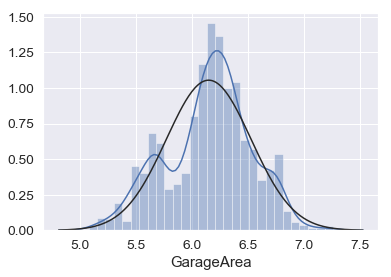

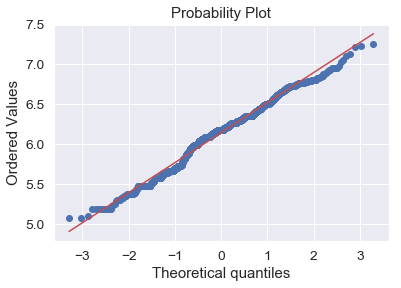

In [29]:
sns.distplot(garageArea_log, fit=norm);
fig = plt.figure()
res = stats.probplot(garageArea_log, plot=plt)

In [30]:
print("Skewness: %f" % train[train['GarageArea']>0]['GarageArea'].skew())
print("Kurtosis: %f" % train[train['GarageArea']>0]['GarageArea'].kurt())

Skewness: 0.811037
Kurtosis: 1.189637


Es scheint als hätten wir uns ein wenig von der Normalverteilung wegbewegt weshalb wird von einer log-Transformierung von "GarageArea" absehen werden.

#### GrLivArea
Wohnbereich über dem Grund in square feet. Erwartet werden float64 Werte, keine negativen und keine fehlenden Werte.

No NAs
No negative values
count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64
Head
0    1710
1    1262
2    1786
Name: GrLivArea, dtype: int64


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


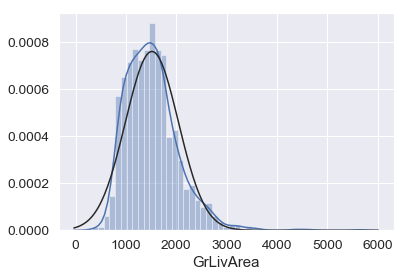

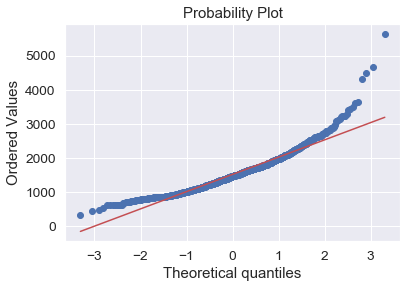

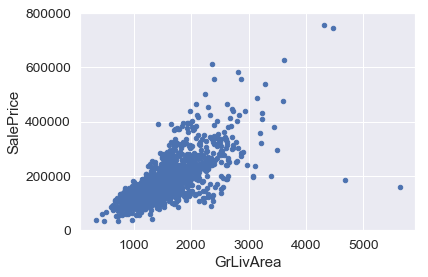

In [31]:
checkFeature('GrLivArea', train, False)

In [32]:
printSkewKurt('GrLivArea', train)

Skewness: 1.366560
Kurtosis: 4.895121


Verteilung scheint in Ordnung und es liegt eine lineare Beziehung vor. Dies war auch so zu erwarten dass mit steigender Größe des Wohnbereichs auch der Verkaufspreis ansteigt.

Trotzdem starten wir auch hier den Versuch einer log-Transformation und sehen wie sich die Verteilung ändert.

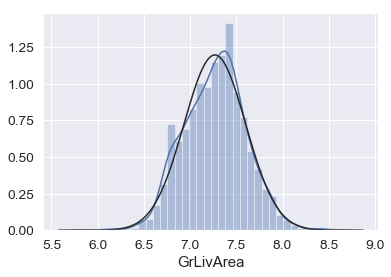

In [33]:
grLivArea_log = np.log(train['GrLivArea'])
sns.distplot(grLivArea_log, fit=norm)

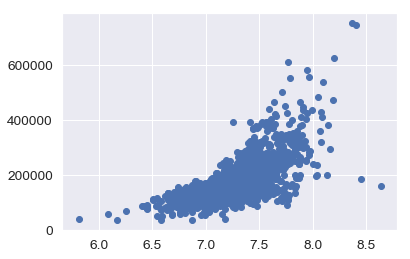

In [34]:
plt.scatter(grLivArea_log, train.SalePrice)

Die Daten sind jetzt zwar annähernd normalverteilt, die Beziehung zur Zielvariable SalePrice ist aber nicht mehr linear. Wir sehen daher von der log-Transformierung ab.

#### FullBath

Volle Badzimmer über dem Grund. Erwartet werden Ganzzahlen, keine negativen und keine fehlenden Werte.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


No NAs
No negative values
count    1460.000000
mean        1.565068
std         0.550916
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: FullBath, dtype: float64
Head
0    2
1    2
2    2
Name: FullBath, dtype: int64


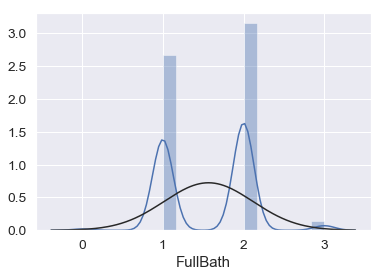

<Figure size 432x288 with 0 Axes>

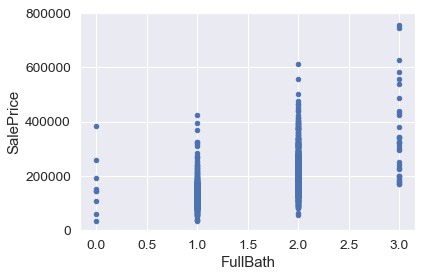

In [35]:
checkFeature('FullBath', train, True)

Wir sehen, es gibt 4 Kategorien von Bädern. 0-4 Stück pro Objekt. Eine Umwandlung in kategorische Variablen ist nicht wünschenswert da wir die Wertung beibehalten wollen. Mehr Badezimmer sind nunmal mehr wert als weniger.

#### TotalBsmtSF
Summe der square feet des Kellers. Erwartet werden float Werte, keine negativen und keine fehlenden Werte.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


No NAs
No negative values
count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64
Head
0     856
1    1262
2     920
Name: TotalBsmtSF, dtype: int64


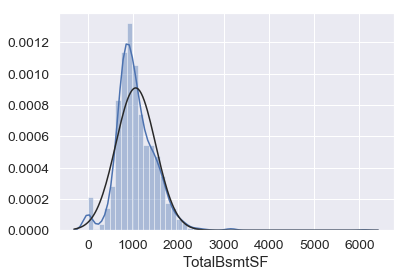

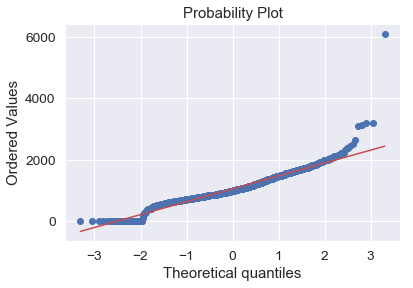

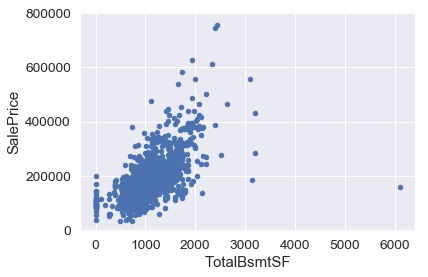

In [36]:
checkFeature('TotalBsmtSF', train, False)

Auch hier sieht es nach einer linearen Beziehung aus bei der eine schöne Verteilung vorliegt. Die einzige Sache welche zu bedenken ist, wie gehen wir mit den 0 Werten (kein Keller) um. Wir wenden die selbe Vorgehensweise als bei "GarageArea" an da die Ausgangssituation nahezu ident ist und prüfen, ob eine log-Transformation Sinn macht.

In [37]:
printSkewKurt('TotalBsmtSF', train)

Skewness: 1.524255
Kurtosis: 13.250483


In [38]:
train['HasBasement'] = pd.Series(len(train['TotalBsmtSF']), index=train.index)
train['HasBasement'] = 0 
train.loc[train['TotalBsmtSF']>0,'HasBasement'] = 1

In [39]:
train.loc[train['HasBasement']==1,'TotalBsmtSF'] = np.log(train['TotalBsmtSF'])

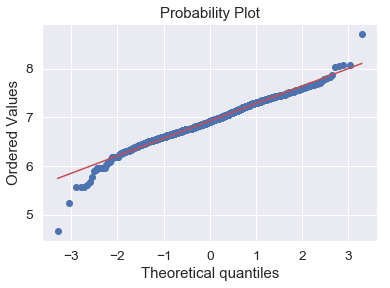

In [40]:
fig = plt.figure()
res = stats.probplot(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

In [41]:
print("Skewness: %f" % train[train['TotalBsmtSF']>0]['TotalBsmtSF'].skew())
print("Kurtosis: %f" % train[train['TotalBsmtSF']>0]['TotalBsmtSF'].kurt())

Skewness: -0.275816
Kurtosis: 1.934678


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


No NAs
No negative values
count    1460.000000
mean        6.749534
std         1.145685
min         0.000000
25%         6.679285
50%         6.899219
75%         7.168772
max         8.717682
Name: TotalBsmtSF, dtype: float64
Head
0    6.752270
1    7.140453
2    6.824374
Name: TotalBsmtSF, dtype: float64


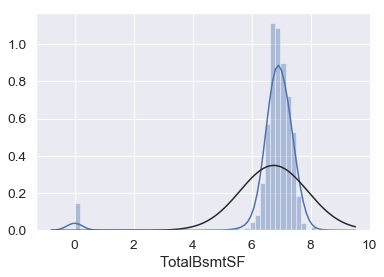

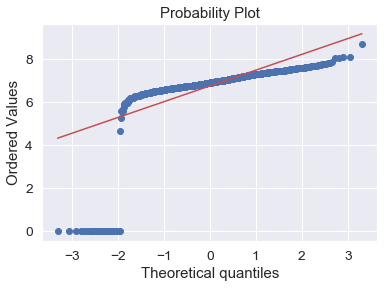

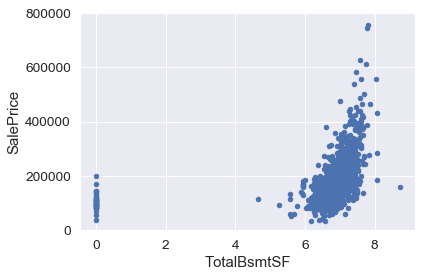

In [42]:
checkFeature('TotalBsmtSF', train, False)

Hier sieht es nach einer Verbesserung im Sinne von einer Annäherung an eine Normalverteilung aus weshalb die log-Transformierung beibehalten wird.

### Scatterplot wichtiger numerischer Features
Mittels Scatterplot-Matrix betrachten wir die Zusammenhänge unserer Ziel-Variable mit den bereits weiter oben gefundenen vielversprechenden Feature-Variablen
* YearBuilt - wann das Objekt erbaut wurde
* GarageArea - Platz der Garage in square feet
* GrLivingArea - Wohnbereich über dem Grund in square fett
* FullBath - Volle Badzimmer über dem Grund. Interessat wäre noch zu wissen, was mit "Voll" gemeint ist.
* TotalBsmtSF - Summe der square feet des Keller

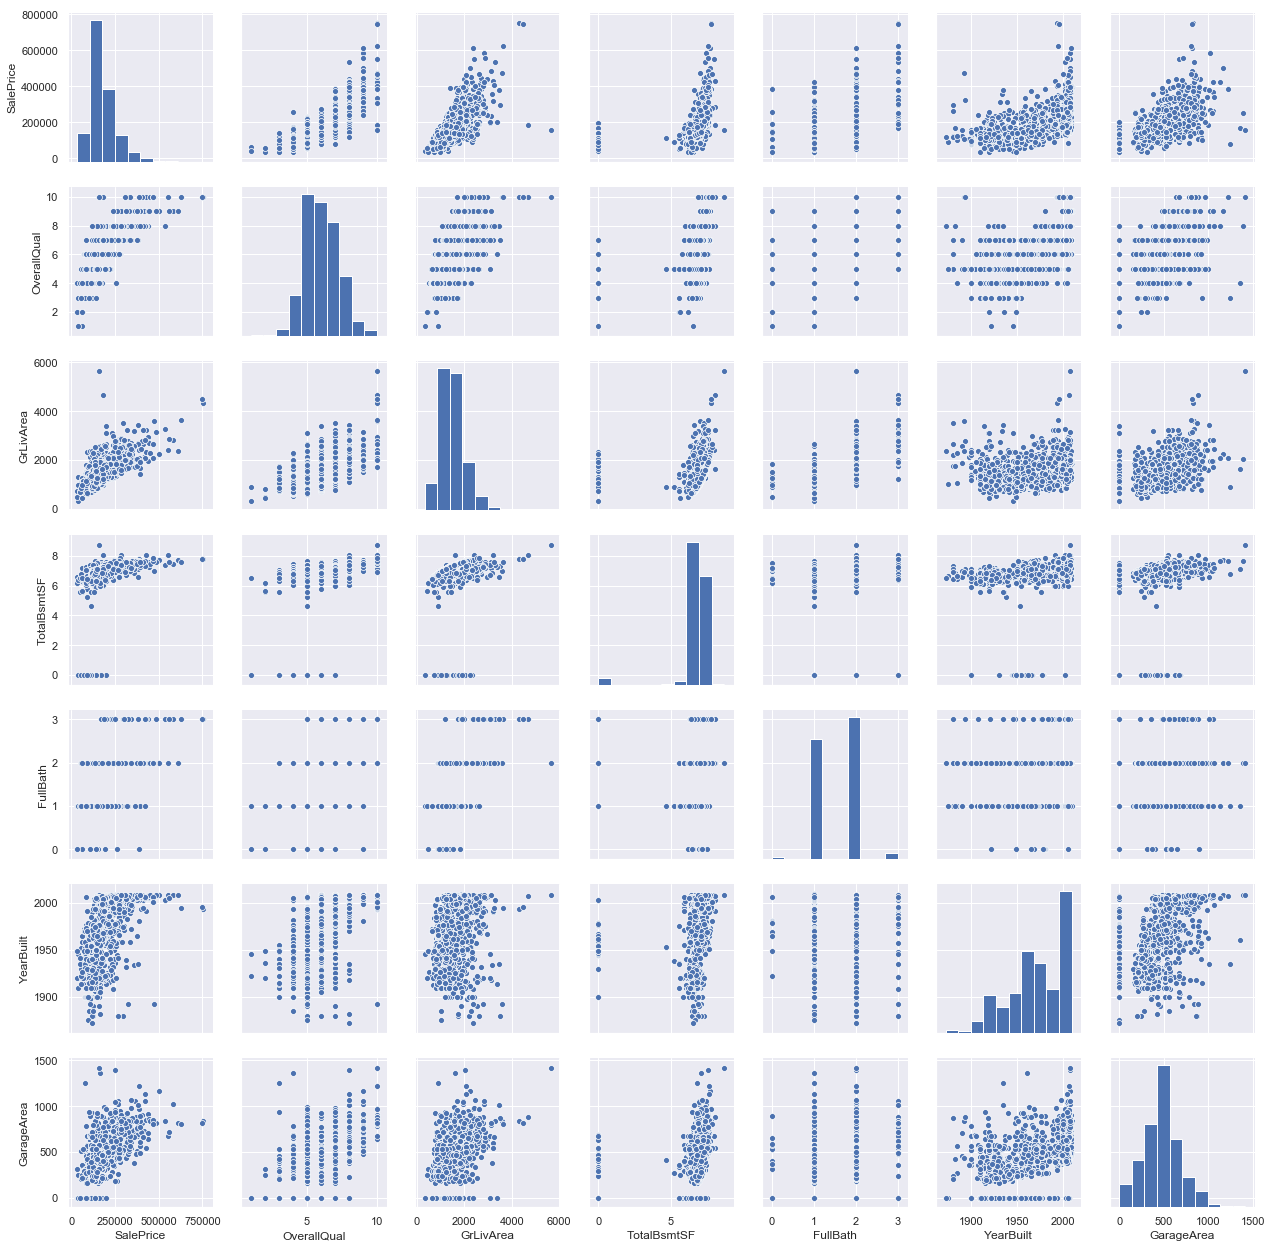

In [43]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'GarageArea']
sns.pairplot(train[cols], size = 2.5)
plt.show();

Die Scatter-Plots zeigen keine Überraschungen. SalesPrice zeigt 4 Punkte welche herausstechen und möglicherweise Outlier sind. Bei TotalBsmtSF ist vor allem ein Punkt sehr markant weit außen und einer näheren Betrachtung wert.

### Zusammenfassung der Analyse der numerischen Feature-Variablen
Nach Begutachtung der vielversprechendsten Feature-Variablen wird das Trainings-Datenset wie folgt aufgebaut:

* YearBuilt - wird nicht geändert
* GarageAreas - wird nicht geändert (GarageCars wird weggelassen)
* GrLivingArea - wird nicht geändert
* FullBath - wird nicht geändert
* TotalBsmtSF - log-Transformierung
* OverallQual - wird nicht geändert

Der 

In [44]:
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,HasGarage,HasBasement
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,6.752270,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,1,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,7.140453,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,1,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,6.824374,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,1,1


### Kategoriale Features

#### Impute NA's

Es gibt noch einige NA-Werte im Datensatz. Diese versuchen wir zu imputen.

In [45]:
train.loc[:,train.isna().any()].isna().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

#### LotFrontage
Linear feet of street connected to property. Ein numerischer Wert, den wir mit dem Median imputen:

In [46]:
data = train.copy()

simple_imputer = SimpleImputer(strategy='median')
data['LotFrontage'] = simple_imputer.fit_transform(data[['LotFrontage']])

#### Alley

Laut Definition des Datensatzes auf Kaggle sind in Alley folgende Werte enthalten:
- Grvl Gravel
- Pave Paved
- NA No alley access

Wir ersetzen daher NA durch "NoAl":

In [47]:
simple_imputer = SimpleImputer(strategy='constant', fill_value = 'NoAl')
data['Alley'] = simple_imputer.fit_transform(data[['Alley']])

#### FireplaceQu
NA bedeutet in diesem Fall, dass es keine Fireplace gibt. Wir ersetzen NA daher durch "No":

In [48]:
simple_imputer = SimpleImputer(strategy='constant', fill_value = 'No')
data['FireplaceQu'] = simple_imputer.fit_transform(data[['FireplaceQu']])

#### Garage

Die NA Werte in den Garage-Features treten nur dann auf, wenn es keine Garage gibt. Daher ersetzen wir wieder alle NAs durch "No". Das numerische Attribut `GarageYrBlt` setzen wir auf `YearBuilt`:

In [49]:
data['GarageType'] = simple_imputer.fit_transform(data[['GarageType']])
data['GarageFinish'] = simple_imputer.fit_transform(data[['GarageFinish']])
data['GarageQual'] = simple_imputer.fit_transform(data[['GarageQual']])
data['GarageCond'] = simple_imputer.fit_transform(data[['GarageCond']])

data.loc[data.GarageYrBlt.isna(),'GarageYrBlt'] = data.YearBuilt

#### Basement

In [50]:
simple_imputer = SimpleImputer(strategy='constant', fill_value = 'No Basement')

data['BsmtQual'] = simple_imputer.fit_transform(data[['BsmtQual']])
data['BsmtCond'] = simple_imputer.fit_transform(data[['BsmtCond']])
data['BsmtExposure'] = simple_imputer.fit_transform(data[['BsmtExposure']])
data['BsmtFinType1'] = simple_imputer.fit_transform(data[['BsmtFinType1']])
data['BsmtFinType2'] = simple_imputer.fit_transform(data[['BsmtFinType2']])

#### PoolQc
Auch in diesem Fall bedeutet NA, dass kein Pool vorhanden ist.

In [51]:
simple_imputer = SimpleImputer(strategy='constant', fill_value = 'No')
data['PoolQC'] = simple_imputer.fit_transform(data[['PoolQC']])

#### Fence
NA bedeutet es gibt keinen Zaun.

In [52]:
simple_imputer = SimpleImputer(strategy='constant', fill_value = 'No')
data['Fence'] = simple_imputer.fit_transform(data[['Fence']])

#### MiscFeature

kann folgende Werte haben:
- Elev Elevator
- Gar2 2nd Garage (if not described in garage section)
- Othr Other
- Shed Shed (over 100 SF)
- TenC Tennis Court
- NA   None

Wir legen für Shed und Tennis Court eine eigene Variable an. "Elevator" kommt gar nicht vor, "Other" lassen wir weg, da es nichts aussagt.

In [53]:
dummies = pd.get_dummies(data.MiscFeature)
dummies.head(10)

,Gar2,Othr,Shed,TenC
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
5,0,0,1,0
6,0,0,0,0
7,0,0,1,0
8,0,0,0,0
9,0,0,0,0


In [54]:
data = pd.concat([data, dummies[['Shed', 'TenC']]],axis=1)

Wir schauen uns noch das MiscFeature "Gar2" an (2nd Garage). Es gibt nur 2 Einträge, wir erhöhen daher einfach die Anzahl Garagenplätze (GarageCars) um 1.

In [55]:
data.loc[data.MiscFeature == 'Gar2', data.columns.str.startswith('Garage') | (data.columns == 'MiscFeature')]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,MiscFeature
346,Attchd,1960.0,RFn,1,301,TA,TA,Gar2
1230,BuiltIn,1977.0,RFn,2,600,TA,TA,Gar2


In [56]:
data.loc[data.MiscFeature=='Gar2','GarageCars'] = data.GarageCars + 1
data = data.drop('MiscFeature', axis=1)

#### Electrical

hier gibt es nur einen NA-Wert, wir ersetzen ihn mit der Most-Frequent-Strateie.

In [57]:
simple_imputer = SimpleImputer(strategy='most_frequent')
data['Electrical'] = simple_imputer.fit_transform(data[['Electrical']])


#### Masonery Veneer

In [58]:
data.loc[pd.isna(data.MasVnrType), 'MasVnrArea'] = 0
data.loc[pd.isna(data.MasVnrType), 'MasVnrType'] = 'None'

### Neue Features

Wir erzeugen aus den vorhandenen Features noch neue, von denen wir glauben dass sie als Prädiktoren geeignet sein könnten.

#### HasBasement
ob ein Haus einen Keller hat, könnte durchaus relevant für den Preis sein.

In [59]:
data['HasBasement'] = 0
data.loc[data['TotalBsmtSF']>0,'HasBasement'] = 1

#### HasPool

In [60]:
data['HasPool'] = 0
data.loc[data.PoolArea>0,'HasPool'] = 1

### Log-Transformation der Ziel-Variable

No NAs
No negative values
count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64
Head
0    12.247694
1    12.109011
2    12.317167
Name: SalePrice, dtype: float64


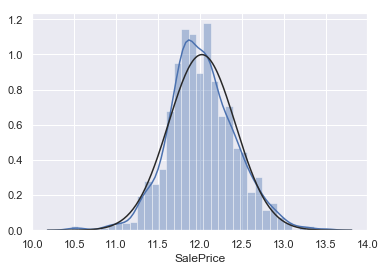

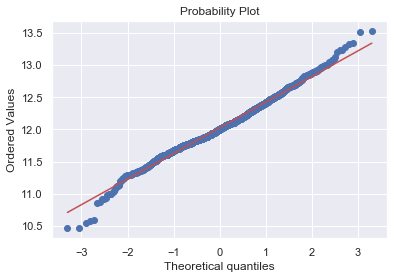

In [61]:
data['SalePrice'] = np.log(data['SalePrice'])
checkFeature('SalePrice', data, False)

Nach Skalierung und der log-Transformation ist jetzt eine besser Verteilung der Ziel-Variable gegeben. Der Probability-Plot (eine Spezialform des Q-Q Plots) zeigt uns, dass die Daten nahe an der roten Linie liegen was auf eine Normalverteilung deutet. Dies wird durch das darüber befindliche Histogramm ebenfalls bestätigt wodurch unsere Ziel-Variable soweit für die Modellierung vorbereitet ist.

### Random Forest für Feature Selection

Abgesehen von Variablen die eine hohe Korrelation mit der Zielvariablen haben, können auch andere Features einen Einfluss auf den SalePrice haben, vor allem auch die kategorialen.
Um Features mit einer hohen Importance herauszufinden, führen wenden wir einen Random Forest auf unsere Daten an, und sehen uns die resultierende Importance an.

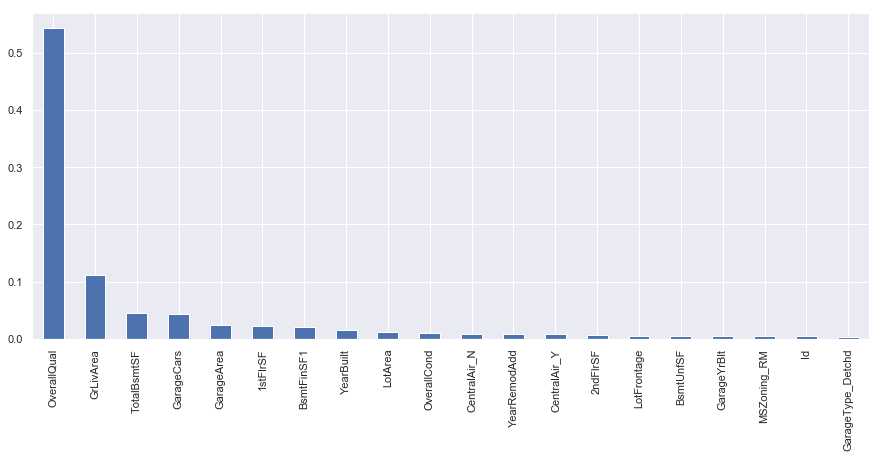

In [62]:
data_rf_feat_sel = pd.get_dummies(data)
X = data_rf_feat_sel.drop('SalePrice', axis=1)
y = data_rf_feat_sel.SalePrice
forest_regressor = RandomForestRegressor(n_estimators = 100 , random_state = 6768)

forest_regressor.fit(X, y)

importance = pd.Series(forest_regressor.feature_importances_, index=X.columns)

plt.figure(figsize=(15,6))
importance.nlargest(20).plot(kind='bar')

In [63]:
perm = PermutationImportance(forest_regressor, random_state=1).fit(X, y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.4151 ± 0.0270,OverallQual
0.1763 ± 0.0070,GrLivArea
0.0418 ± 0.0024,TotalBsmtSF
0.0249 ± 0.0033,GarageCars
0.0224 ± 0.0026,BsmtFinSF1
0.0178 ± 0.0013,1stFlrSF
0.0130 ± 0.0009,GarageArea
0.0126 ± 0.0013,YearBuilt
0.0102 ± 0.0004,LotArea
0.0089 ± 0.0012,OverallCond


OverallQual ist mit Abstand die stärkste Feature Variable. Wir haben alle wichtigen Features aber bereits bei den vorherigen Analysen berücksichtigt. Die verschiedenen Flächen-Features (SF) korrelieren miteinander, wir konzentrieren uns also auf GrLivArea und TotalBsmtSF.

Auch der Score der Permutation Importance deutet auf eine sehr starke Korrelation zwischen OverallQual und SalesPrice hin. Es wird sich zeigen, wie ein Modell welches nur mit OverallQual arbeitet im Vergleich zu komplexeren Modellen abschneidet.

# Modelle

Nach Abschluss des Feature Engineerings können wir die Daten jetzt in einen Trainings und Testdatensatz aufteilen. Anschließen fitten wir verschiedene Modelle, die wir mit einer Evaluierungsfunktion überprüfen.
Als Maß für die Modellgüte verwenden wir den adjusted R<sup>2</sup> und RMSE.

## Aufbau Test und Train Datenset

Derzeitiger Stand des Datensets:

Da in den Testdaten von Kaggle die Zielvariable nicht enthalten ist, splitten wir uns ein Testset von den Trainingsdaten ab.

In [64]:
data = data_rf_feat_sel
train_X, test_X, train_y, test_y = train_test_split(data.drop('SalePrice',axis=1), 
                                                    data.SalePrice, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [65]:
result = pd.DataFrame(columns=['rmse', 'r2'])

## Lineares Modell mit reduzierten Prädiktoren

In [66]:
features = ['YearBuilt','GarageArea','OverallQual', 'GrLivArea', 'TotalBsmtSF', 'FullBath']
train_reduced = train_X[features].copy()
test_reduced = test_X[features].copy()

In [67]:
lin_reg = LinearRegression()
lin_reg.fit(train_reduced, train_y)
rmse, r2 = eval_model(lin_reg, test_reduced, test_y)
result = result.append(pd.Series({'rmse':rmse, 'r2': r2}, name='Lin. Regression Reduced Features'))

r2 = 0.8312264941638686
rmse = 33908.85345074706


## Lineares Modell mit allen Features

Wir versuchen nun, ob das Verwenden von allen verfügbaren Features zu einem besseren Ergebnis führt

In [68]:
lin_reg = LinearRegression()
lin_reg.fit(train_X,train_y)

print('train score = ' + str(lin_reg.score(train_X, train_y)))

train score = 0.9453595654103115


In [69]:
rmse, r2 = eval_model(lin_reg, test_X, test_y)
result = result.append(pd.Series({'rmse':rmse, 'r2': r2}, name='Linear Regression'))

r2 = 0.9050861139636928
rmse = 22969.73174038602


Im Vergleich zum Modell mit reduzierten Features haben sich sowohl der RMSE als auch der R<sup>2</sup> wesentlich verbessert. Unser Modell erklärt nur bereits 90% der Varianz in den Daten.

## Lineares Modell nur mit OverallQual

In [70]:
train_ovqual = train_reduced['OverallQual'].copy()
test_ovqual = test_reduced['OverallQual'].copy()

In [71]:
train_ovqual = np.array(train_ovqual).reshape(-1,1)
test_ovqual = np.array(test_ovqual).reshape(-1,1)

In [72]:
lin_reg_oq = LinearRegression()
lin_reg_oq.fit(train_ovqual, train_y)
rmse, r2 = eval_model(lin_reg_oq, test_ovqual, test_y)
result = result.append(pd.Series({'rmse':rmse, 'r2': r2}, name='Lin. Regression only OverallQual'))

r2 = 0.7138205628839369
rmse = 47869.610302914996


OverallQual ist zwar eine sehr signifikante Variable, erklärt aber nur rund 70% unseres Modells. 

## Ridge

Alle Features zu verwenden, kann leicht zu Overfitting führen. Wir untersuchen daher, ob eine Regularisierung mit Ridge oder Lasso zu einer Verbesserung des Modells führt.

Bei der Ridge Regularisierung wird die Quadratsumme der Koeffizienten mit einem Faktor `alpha` multipliziert und zur Lossfunktion addiert. Dadurch werden hohe Koeffizienten "bestraft". Je höher `alpha`, desto mehr werden die Koeffizienten eingeschränkt.

In [73]:
rr = Ridge(alpha=0.01)
rr.fit(train_X, train_y)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [74]:
rmse, r2 = eval_model(rr, test_X, test_y)
result = result.append(pd.Series({'rmse':rmse, 'r2': r2}, name='Ridge Regression'))

r2 = 0.9118601966718928
rmse = 22754.40970617652


Wir haben eine kleine Verbesserung gegenüber der OLS Regression mit allen Features erreicht. RMSE und R<sup>2</sup> haben sich leicht verbessert.

## Lasso

Bei der Lasso Regularisierung wird statt der Summe der Quadrate die Summer der Absolutwerte verwendet. Dadurch werden bei höherem `alpha` immer mehr Koeffizienten zu 0.

In [75]:
lasso = Lasso(alpha=0.001)
lasso.fit(train_X,train_y)
rmse, r2 = eval_model(lasso, test_X, test_y)
result = result.append(pd.Series({'rmse':rmse, 'r2': r2}, name='Lasso Regression'))

r2 = 0.8955876364125712
rmse = 25971.568271535234


Mit der Lasso Regression kommen wir nicht an die Ergebnisse der Ridge Regression und der OLS Regression heran. Wir schließen daraus, dass der Preis eines Hauses doch von viele Features beeinflusst wird. Die Lasso Regression setzt viele Koeffizienten auf 0 und vereinfacht das Modell damit zu sehr.

## Random Forest

Wir trainieren einen Random Forest einmal mit allen Features, und einmal nur mit den reduzierten Features

In [76]:
forest_regressor = RandomForestRegressor(n_estimators=100, random_state = 3333)
forest_regressor.fit(train_X, train_y)

print('train score = ' + str(forest_regressor.score(train_X, train_y)))
rmse, r2 = eval_model(forest_regressor, test_X, test_y)
result = result.append(pd.Series({'rmse':rmse, 'r2': r2}, name='Random Forest'))

train score = 0.9809618596824796
r2 = 0.8785554787591887
rmse = 29443.27669725156


### Random Forest mit reduzierten Features


In [77]:
forest_regressor = RandomForestRegressor(n_estimators=10, random_state = 3333)
forest_regressor.fit(train_reduced, train_y)

print('train score = ' + str(forest_regressor.score(train_reduced, train_y)))
eval_model(forest_regressor, test_reduced, test_y)

train score = 0.9631016631327107
r2 = 0.82784159539834
rmse = 34804.642934375006


(34804.642934375006, 0.82784159539834)

In [78]:
forest_regressor = RandomForestRegressor(n_estimators=5000, max_features='sqrt', random_state = 3333)
forest_regressor.fit(train_reduced, train_y)

print('train score = ' + str(forest_regressor.score(train_reduced, train_y)))
eval_model(forest_regressor, test_reduced, test_y)

train score = 0.9768253640141198
r2 = 0.8472920020172119
rmse = 30931.16946288584


(30931.16946288584, 0.8472920020172119)

Bei den beiden obrigen RF Modellen wurden die Parameter ohne bestimmten Grund gewählt. Nachfolgend wird mittels RandomizedSearchCV (RCV)versucht, die besten Parameter zu finden. 

## Random Forest Parameter Tuning

Normalerweise haben wir nur eine vage Vorstellung von den besten Hyperparametern und daher ist der beste Ansatz, unsere Suche einzugrenzen und eine breite Reichweite von Werten für jeden Hyperparameter festzulegen. RCV versucht dann durch zufällige Stichproben mit K-Fold Kombinationen, die besten Parameter zu finden.

Sehen wir uns die Parameter des oben erstellten RF Modells an:

In [79]:
pprint(forest_regressor.get_params())

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 5000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 3333,
 'verbose': 0,
 'warm_start': False}


Die Liste ist recht umfangreich und wir werden uns auf die nachfolgenden Parameter fokusieren. Eine kurze Erklärung zu den gewählten Parametern:
* n_estimators: Anzahl der Bäume im Wald
* max_features: Maximum der Features welche beim Split berücksichtigt werden
* max_depth: Maximale Tiefe (Anzahl Ebenen) in Baum
* min_samples_split: Minimale Anzahl an Proben welche notwendig für einen Split ist
* min_samples_leaf: Minimum Anzahl der Datenpunkte in Blatt Knoten
* bootstrap: Welche Methode zur Auswahl der Probe für jeden Baum gewählt wird

In [80]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


Der Algorithmus wird bei jedem Durchlauf nun einen andere Kombination aus den Parametern verwenden. Das ergibt insgesamt 4320 Möglichkeiten. Das sind zwar viele, aber noch lange nicht alle Möglichen.

In [81]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, 
                               n_jobs = -1)

In [82]:
%%time
%%capture

rf_random.fit(train_reduced, train_y)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

Wall time: 7min 26s


Die wichtigsten Argumente bei RandomizedSearchCV sind n_iter (Anzahl der verschiedenen zu testenden Kombinationen) und cv (Anzahl der Folds für die Cross-Validation). Mehr Iterationen decken einen größeren Suchraum ab. Mehr CV-Folds verringern die Wahrscheinlichkeit von Overfitting, verlängern jedoch die Laufzeit. Wie immer gilt, *there is no free lunch*

Sehen wir uns die gefundenen *besten* Parameter an:

In [83]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 400}

Durch diese *zufällige Suche* nach den besten Parametern, haben wir jetzt eine gute Basis und können mittels GridSearch mit CrossValidation noch weiter in die Tiefe gehen. Dafür geben wir explizite Werte an welche probiert werden sollen.

In [84]:
param_grid = {
    'n_estimators': [100, 300, 600, 900],
    'min_samples_split': [8, 10, 12],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt'],
    'max_depth': [20, 30, 40, 50],
    'bootstrap': [False]    
}

In [85]:
rf_grid = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [86]:
%%time
%%capture
grid_search.fit(train_reduced, train_y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 300, 600, 900], 'min_samples_split': [8, 10, 12], 'min_samples_leaf': [1, 2, 5], 'max_features': ['sqrt'], 'max_depth': [20, 30, 40, 50], 'bootstrap': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

Wall time: 3min 33s


In [87]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 600}

In [88]:
best_grid = grid_search.best_estimator_
rmse, r2 = eval_model(best_grid, test_reduced, test_y)
result = result.append(pd.Series({'rmse':rmse, 'r2': r2}, name='Tuned Random Forest'))

r2 = 0.8456416280953669
rmse = 30887.988502986846


Trotz der Suche nach den besten Parametern, konnte gegenüber den einfachen RF Modellen zu Beginn dieses Abschnittes, keine Verbesserung erzielt werden. Das mag daran liegen, dass der Random-Search eben Random ist und nicht zwingend die besten Parameter liefert. Bei mehrmaliger Ausführung, werden auch nicht immer die selben Werte retourniert.

## XGBoost

Da Xtreme Gradient Boosting ein prominenter Algorithmus ist, der bei Kaggle Competitions immer gut abschneiden, wollen wir sehen, wie er auf unseren Daten abschneidet.

In [89]:
xgb = XGBRegressor(n_estimators=2000, learning_rate=0.1)
xgb.fit(train_X, train_y)

[20:30:24] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [90]:
rmse, r2 = eval_model(xgb, test_X, test_y)
result = result.append(pd.Series({'rmse':rmse, 'r2': r2}, name='Extreme Gradient Boosting'))

r2 = 0.8858753260250666
rmse = 32685.752167466784


Auch der XGBoost kann unser simples lineares Modell und die Ridge Regression nicht schlagen. Wir versuchen es noch mit Parametertuning, insbesondere mit verschiedenen Boostern.

### XGBoost Parameter Tuning

In [91]:
param_grid = {'n_estimators': [1000],
              'learning_rate': [0.01, 0.05, 0.1],
              'booster': ['gbtree', 'gblinear', 'dart']
             }

In [92]:
%%capture
xgb_tuned = GridSearchCV(estimator = XGBRegressor(),param_grid = param_grid )
xgb_tuned.fit(train_X, train_y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1000], 'learning_rate': [0.01, 0.05, 0.1], 'booster': ['gbtree', 'gblinear', 'dart']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [93]:
xgb_tuned.best_params_

{'booster': 'gbtree', 'learning_rate': 0.1, 'n_estimators': 1000}

In [94]:
eval_model(xgb_tuned, test_X, test_y)

r2 = 0.8864210057123822
rmse = 32659.554290509033


(32659.554290509033, 0.8864210057123822)

# Results

Die linearen Modelle (normale lineare Regression und Ridge) liefern die besten Ergebnisse. Das erklärt sich dadurch, dass die Daten auch in Wahrheit einen linearen Zusammenhang haben. Tree-Modelle sind dagegen eher für Daten geeignet, die sich in rechteckige Regionen clustern lassen.

Die folgende Tabelle listet den RMSE und den adjusted R<sup>2</sup> für unsere trainierten Modelle auf. Die Ridge und die normale Regression sind praktisch gleich auf die besten.

Die Random Forest Regression, mit der wir unsere Analyse begonnen haben, hängen wird auch noch an.

In [95]:
result = result.append(pd.Series({'rmse':rmse_intro, 'r2': r2_intro}, name='Random Forest Intro'))

In [96]:
result.sort_values(by='rmse')

,rmse,r2
Ridge Regression,22754.409706,0.911860
Linear Regression,22969.731740,0.905086
Lasso Regression,25971.568272,0.895588
Random Forest Intro,29183.491325,0.862180
Random Forest,29443.276697,0.878555
Tuned Random Forest,30887.988503,0.845642
Extreme Gradient Boosting,32685.752167,0.885875
Lin. Regression Reduced Features,33908.853451,0.831226
Lin. Regression only OverallQual,47869.610303,0.713821


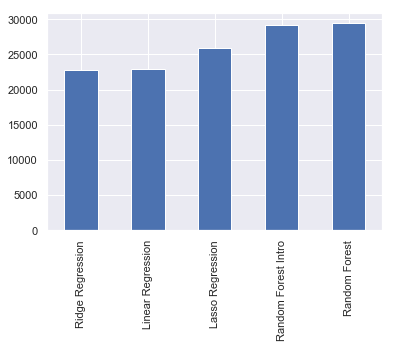

In [97]:
result.rmse.nsmallest().plot(kind='bar')

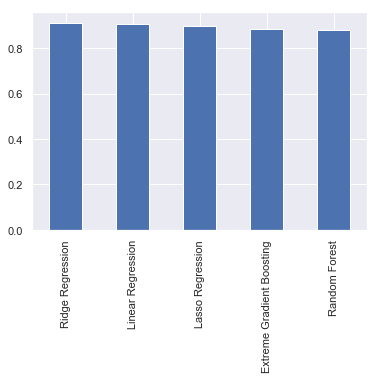

In [98]:
result.r2.nlargest().plot(kind='bar')

## Model Explainabilty

In diesem Abschnitt möchten wir noch kurz beleuchten, wie mit Hilfe von SHAP Values (SHapley Additive exPlanations) und Partial Plots der Outcome eines Modells rückverfolgbar bleibt. Dazu verwenden wir das Modell, bei dem wir den Extreme Gradient Boost eingesetzt haben. Nicht etwa, weil dieser das beste Ergebnis erzielte, sondern weil es bei XGB Modellen im Nachhinein sehr schwierig zu beurteilen ist, welche Variablen mit welchen Werten letztlich zu einem Ergebnis führten. SHAP Analysen werden häufig bei automatisierten Bonitätseinstufungen eingesetzt. Dabei ist es von besonderer Bedeutung, im Nachhinein überprüfen zu können, ob dem Kreditanfragenden nicht wegen eines diskriminierenden Merkmals ein Darlehen verwehrt wurde.

In [99]:
import shap

explainer = shap.TreeExplainer(xgb)

shap_values = explainer.shap_values(train_X)

### SHAP plot
Bei dieser Grafik sehen wir, welche Variablen Einfluss auf den Outcome die vierzehnte Beobachtung genommen haben. Dabei zeigt sich wieder ein ähnliches Bild wie bei den vorangegangenen Analysen. Die Wohnfläche und der OverallQual Wert von 7 wirkt sich stark positiv aus. Das Baujahr senkt den Wert der Immobilie. Auch die Größe des Kellers hat einen negativen Einfluss auf den Wert genommen.

In [100]:
shap.initjs()

beobachtung = 13

shap.force_plot(explainer.expected_value, shap_values[beobachtung,:], train_X.iloc[beobachtung,:])

### Summary plot
Ein umfassenderes Bild zeigt der summary plot. Dabei werden die wichtigsten features und ihr Einfluss auf die einzelnen Beobachtungen abgebildet. Die Wohnfläche und der Zustand der Wohnung haben dabei sowohl den größten positiven als auch negativen Einfluss auf den Wert der Immobilie.

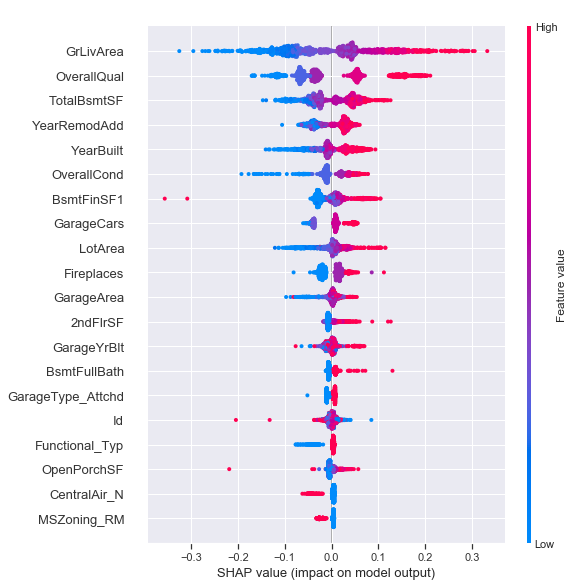

In [101]:
shap_values = explainer.shap_values(train_X)
shap.summary_plot(shap_values, train_X, feature_names=train_X.columns)

### Partial plot
Auch mit partial plots lassen sich interessante Erkenntnisse über den Einfluss der Variablen nehmen. Dabei werden alle Outcomes in Abhängigkeit der Veränderung eines features geplotet. Alle anderen feature werden stabil gehalten. Die folgende Grafik zeigt die Veränderung des Immobilien Preises in der Abhängigkeit der Wohnfläche. Die anfangs stark steigende Kurve zeigt mehrere Datenpunkte auf engem Feld. Das liegt daran das im unteren und mittleren Preissegment die meisten Immobilien vorhanden sind. Zwischen den Werten 2100 und 4300 steigt die Kurve weniger als in der unteren Hälfte der Grafik zu sehen ist. Dies lässt auf einen abnehmenden Grenznutzen von Wohnfläche schließen.

In [102]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

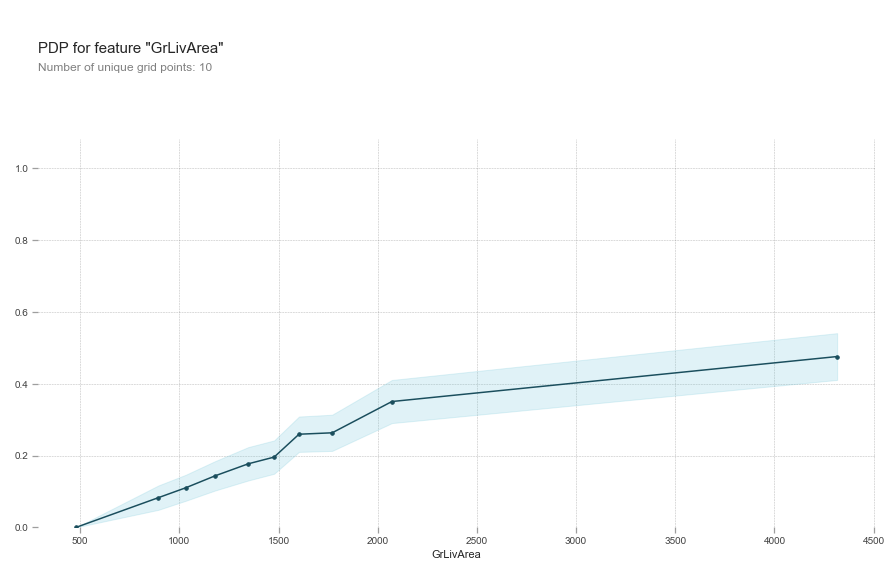

In [103]:
feature_to_plot='GrLivArea'
test_X_df = pd.DataFrame(train_X, columns=input_features)

pdp_dist = pdp.pdp_isolate(model=xgb, dataset=test_X, model_features=train_X.columns, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

### 2D interaktions plot
Der partial plot kann auch für zwei features durchgeführt werden. Folgende Grafik (die Fehlermeldung kann ignoriert werden) zeigt das Zusammenspiel der Wohnfläche und dem Zustand der Immobilie. Dabei ist ein sehr interessanter Effekt zu beobachten, den wir in den vorangegangenen Analysen nicht gesehen haben und somit neu für uns ist. Die untere Hälfte des Plots (gelesen von links unten nach rechts oben) zeigt konkave Kurven. Ab der Mitte hingegen, werden die Kurven immer konvexer. Das bedeutet, dass in der unteren Hälfte der Wert der Immobilie entweder stark von der Qualität oder der Größe abhängt. Konvexe Kurven hingegen sind ein Anzeichen für einen negativen Substitutionseffekt, sprich das Bündel wird gegenüber der Einzelausprägung bevorzugt. Somit kann von einem Interaktionseffekt im höheren Preissegment, der Features GrLivArea und OverallQual ausgegangen werden, im mittleren und unteren Preissegment hingegen ist ein Substitutionseffekt zu beobachten.

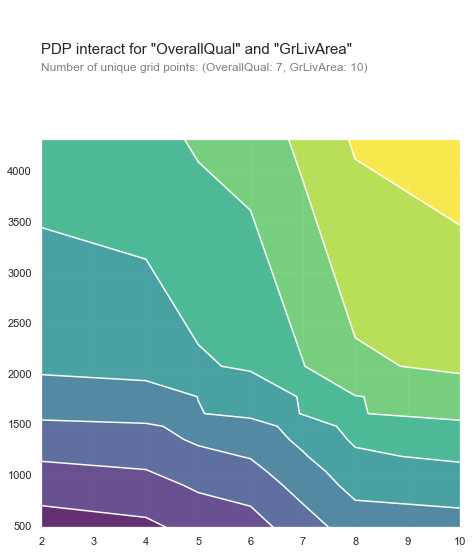

In [104]:
features_to_plot = ['OverallQual', 'GrLivArea']
inter1  =  pdp.pdp_interact(model=xgb, dataset=test_X, model_features=train_X.columns, features=features_to_plot)

try:
    pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
except: TypeError
    

plt.show()

In allen Modellen und Analysen stellte sich jedoch heraus, dass die Features OverallQual und GrLivArea den größten Einfluss auf den Preis haben.

Auch GarageArea ist ein wichtiges Feature, was sich dadurch erklärt, dass Häuser mit Garagen für mehrere Autos überlicherweise dem Luxussegment zuzuordnen sind.